In [1]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr

pd.options.display.html.table_schema = True

# Problem Statement

Often data is incomplete, redundant or degenerate because data stores are developed to capture all the data that *may* be useful, not just the data that *is useful today*. In these instances, as a data scientist, one must exclude that missing, redundant, or degenerate data.

# Solution Explored in this Notebook

1. Use `pandas` to exclude incomplete data,
2. evaluate the [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) correlation coefficients to identify the redundancy/degeneracy of the data, and
3. use the selected correlation matrix as the distance metric in a agglomerative hierarchical clustering algorithm to identify correlations.

# Next Steps

1. From these correlations, reduce the number of input/output variables,
2. feed these into classification/regression algorithms.

This notebook was inspired by a presentation given by Amit Verma on 14 April 2020.

# Read in the data

In [3]:
data = pd.read_csv("data/citrination-export-20200414.csv");

# set index
data.set_index("Name", inplace=True)

# remove uncertainty
columns = [col for col in data.columns if not col.startswith("Uncertainty")]
data = data[columns]

# remove probability
columns = [col for col in data.columns if not col.endswith("probability")]
data = data[columns]

# remove "Property" from column names
columns = [re.sub("Property ", "", col) for col in data.columns]
data.columns = columns

# remove columns whose records are all identical (degenerate columns)
# columns = [c for c in data.columns if np.all(data[c] == data.loc[0, c])]
# data.drop(columns, axis=1)

# remove statistical values
columns = [col for col in data.columns if not col.startswith("mean")]
data = data[columns]

data

,Alpha lath thickness (microns),"Bead quality (1-intermittent, 2-variable, 3-rippled, 4-smooth)",Bead width (mm),Beta grain length // build (microns),Beta grain length perp. build (microns),Fusion zone area (mm^2),Fusion zone depth (mm),Fusion zone depth at 50% fusion zone width (mm),Fusion zone depth at 75% fusion zone width (mm),Fusion zone width (mm),...,Weld Ignition Stage Data: Wobbler Frequency (Hz),Weld Main Stage Data: Heat Wirefeed Speed (mm/s),Weld Main Stage Data: Laser Power (W),Weld Main Stage Data: Travel Speed (mm/s),Weld Main Stage Data: Weave Length (mm),Weld Main Stage Data: Weave Width (mm),Weld Main Stage Data: Weld Power Source/Hotwire Mode,Weld Main Stage Data: Wire Power (kW),Weld Main Stage Data: Wobbler Amplitude (mm),Weld Main Stage Data: Wobbler Frequency (Hz)
Name,,,,,,,,,,,,,,,,,,,,,
N00014-001-001,1.214556,2.0,7.163,292.010222,825.591500,15.019,2.865,1.0280,0.7425,7.198,...,500.0,15.0,3000.0,3.5,4.0,0.05,485.0,0.0,0.0,500.0
N00014-001-002,1.290889,4.0,7.407,205.345556,857.171500,16.045,3.088,0.6775,0.5605,7.353,...,500.0,90.0,6000.0,15.0,4.0,0.05,485.0,0.6,0.0,500.0
N00014-001-003,1.407333,3.0,12.380,431.241913,1087.894000,37.659,4.247,2.1235,1.9140,11.813,...,500.0,35.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
N00014-001-004,1.400000,3.0,12.380,406.341435,1166.432333,45.069,4.710,1.9885,1.5345,13.248,...,500.0,45.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
N00014-001-005,1.273667,4.0,11.452,460.839063,1296.089333,48.420,5.905,1.6075,1.1405,11.564,...,500.0,55.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N00014-003-020,1.284000,2.3,8.400,217.000000,570.000000,11.900,1.770,0.6300,0.8430,8.120,...,0.0,52.2,6000.0,15.0,NaN,0.05,485.0,0.3,0.0,0.0
N00014-003-021,1.370000,2.9,12.500,455.000000,1320.000000,37.100,5.000,1.8300,1.3500,10.900,...,0.0,50.7,6000.0,3.5,NaN,0.05,485.0,0.3,0.0,0.0
N00014-003-022,1.360000,2.9,24.000,383.000000,1340.000000,130.000,5.100,1.9400,1.3700,10.500,...,0.0,50.7,6000.0,5.8,NaN,0.05,485.0,0.3,0.0,0.0


# Calculate Pearson and Spearman correlations between remaining columns

In [202]:
def plot_correlation(df, name="", cmap=None):
    fig, ax = plt.subplots(1, 1, figsize=(11, 9));
    cmap = "Spectral_r" if cmap is None else cmap
    return sns.heatmap(df, vmin=-1, vmax=1, cmap="Spectral_r",
                       ax=ax, cbar_kws={"label": name})

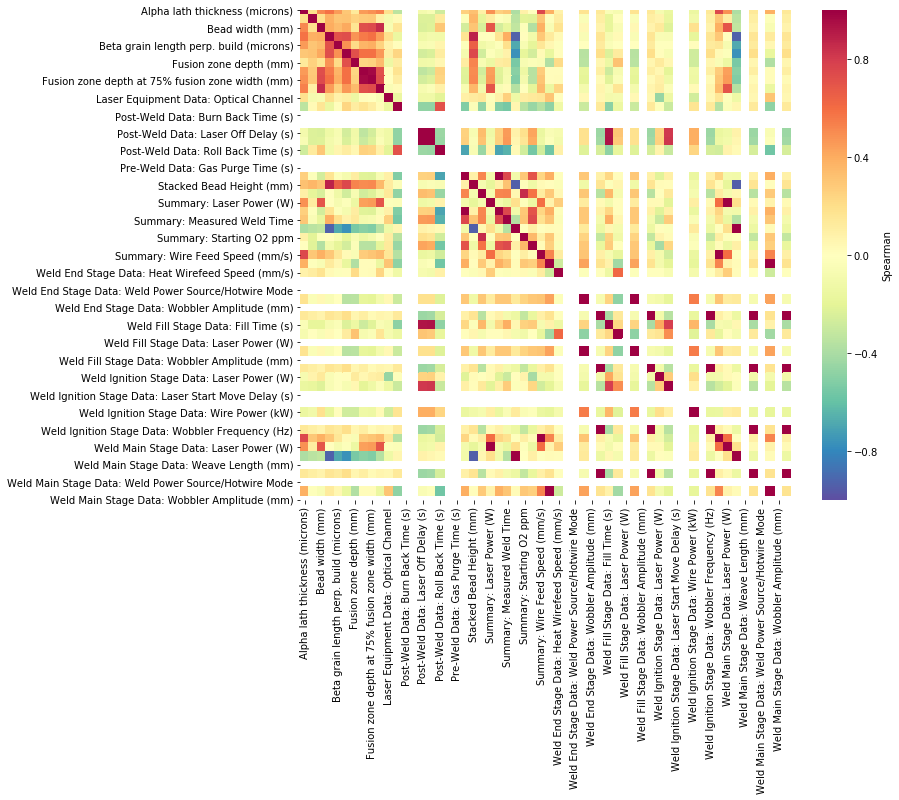

In [203]:
spearman = data.corr("spearman")
plot_correlation(spearman, "Spearman");

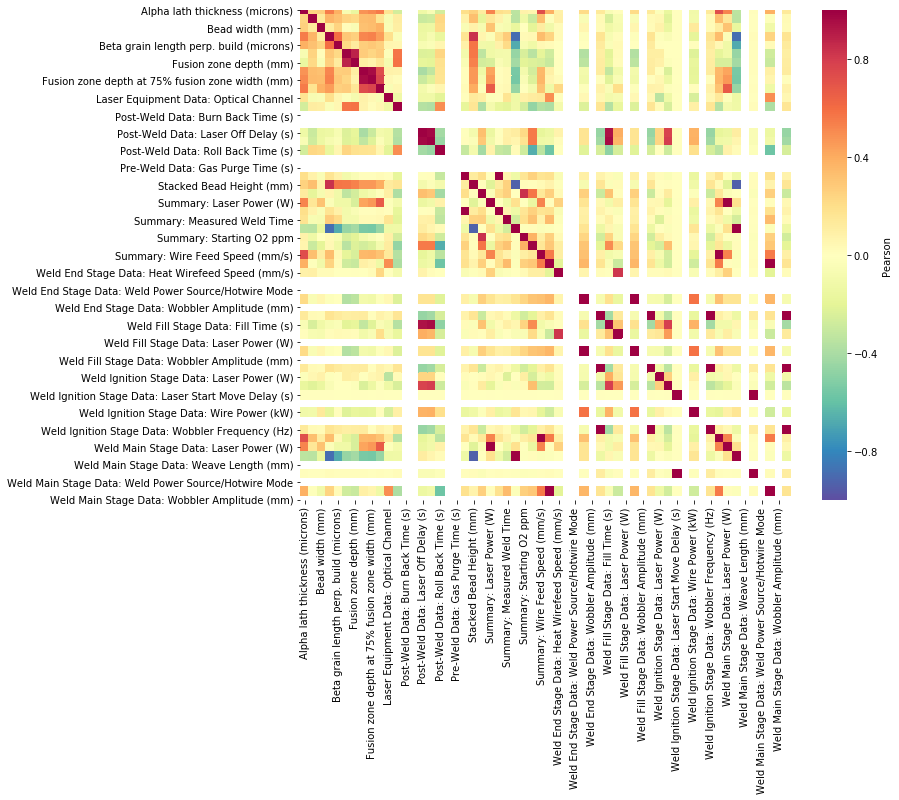

In [204]:
pearson = data.corr("pearson")

plot_correlation(pearson, name="Pearson");

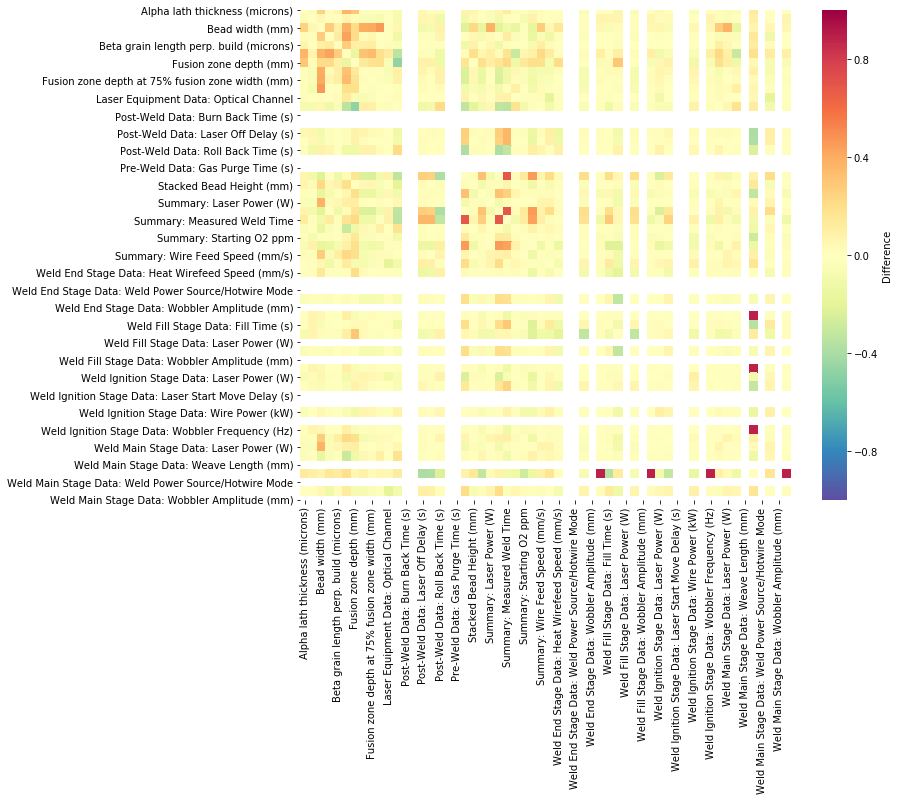

In [205]:
plot_correlation(spearman - pearson, name="Difference");

## Remove columns with non-existent correlation coefficients

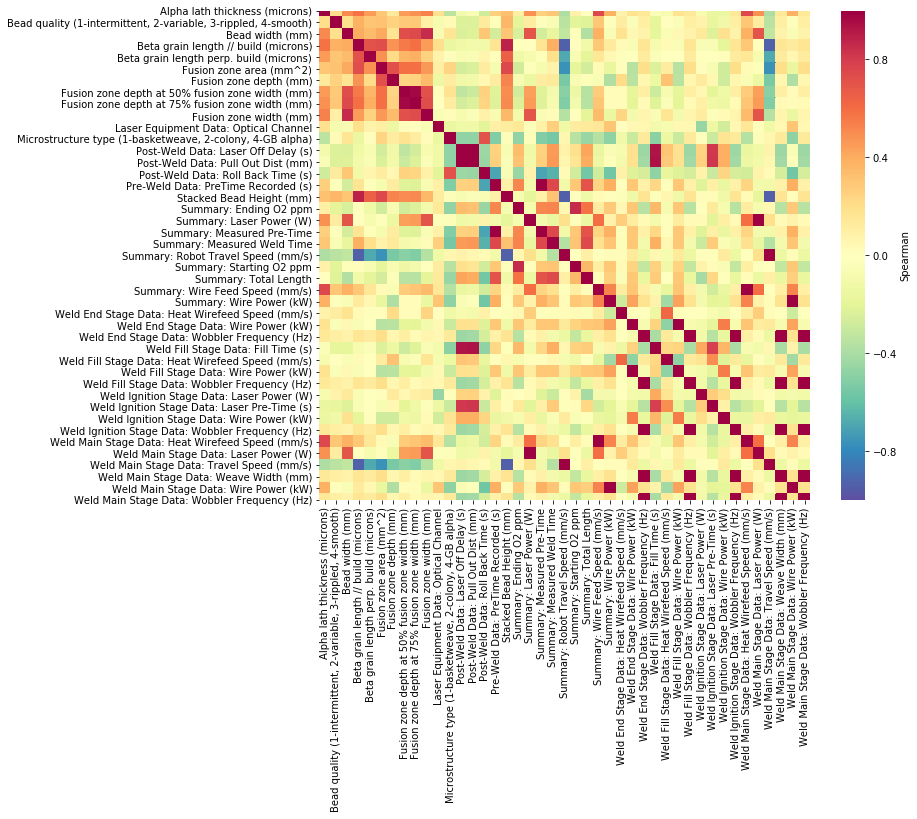

In [206]:
trimmed = data[list(spearman.dropna(how="all").index)]

plot_correlation(trimmed.corr("spearman"), name="Spearman");

## Cluster based on Spearman correlation

In [207]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

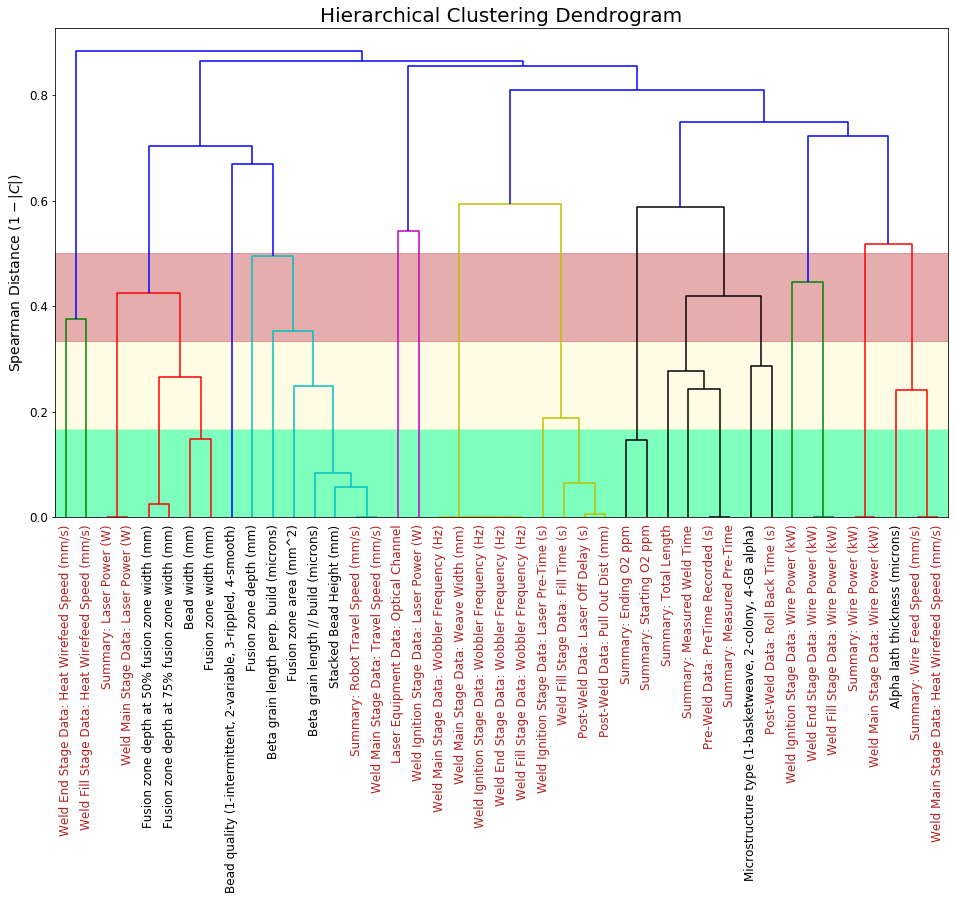

In [224]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs);


# map the column names to an index ({#: "name", ...})
labels = {str(i): c for i,c in enumerate(trimmed.columns)}
X = (1 - np.abs(trimmed.corr("spearman"))).values

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity="precomputed",
                                linkage="average",
                                distance_threshold=0,
                                n_clusters=None)

model = model.fit(X)
# plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode='level', p=3)
fig, ax = plt.subplots(1, 1, figsize=(16, 9));
plot_dendrogram(model, truncate_mode=None, ax=ax)

ax.set_title('Hierarchical Clustering Dendrogram', fontsize=20)
ax.set_xticklabels([labels.get(x.get_text(), "") for x in ax.get_xticklabels()],
                   fontsize=12)#, rotation=45, ha="right")
ax.set_ylabel("Spearman Distance ($1 - |C|$)", fontsize=14)

# draw a horizontal line at a cutoff where merged values have strong, medium, and weakly correlated
ax.axhspan(0, 0.1666, color="springgreen", alpha=0.5)
ax.axhspan(0.1666, 0.3333, color="lemonchiffon", alpha=0.5)
ax.axhspan(0.3333, 0.5, color="indianred", alpha=0.5)

# set color of tick labels to improve grouping/identification
for label in ax.get_xticklabels():
    text = label.get_text()
    if re.match('.*:', text):
        label.set_color("firebrick")
        
for label in ax.get_yticklabels():
    label.set_fontsize(12)

dest = os.path.join(os.path.expanduser("~"),
                    "Desktop",
                    "qm-hierarchical-clustering.png")
plt.savefig(dest, dpi=300, bbox_inches="tight");
plt.show()